# **Assignment 2: Bandits and Exploration/Exploitation**

In this notebook, you will:
- Learn how to create your first bandit algorithm
- Understand the effect of epsilon on exploration and learn about the exploration/exploitation tradeoff
- Be introducing to some of the reinforcement learning software we are going to use for this specialization

This notebook uses RL-Glue to implement most of experiments. It was originally designed by Adam White, Brian Tanner, and Rich Sutton. This library will give you a solid framework to understand how reinforcement learning experiments work and how to run your own.

## **Section 0: Preliminaries**

In [11]:
#---------------------------
# Import necessary libraries
#---------------------------
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env

You might have noticed that we import ten_arm_env. This is the __10-armed Testbed__ introduced in the textbook. We use this throughout this notebook to test our bandit agents. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance. For each action, the expected value of that action is randomly sampled from a normal distribution, at the start of each run. If you are unfamiliar with the 10-armed Testbed please review it in the textbook before continuing.

## **Section 1: Greedy Agent**

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with  the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

First we are going to implement the argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmax function. You may want to look at [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to randomly select from a list of values.

In [12]:
import numpy as np

def argmax(q_values):
    """
    Finds and returns the index of the highest value in a list of q_values.
    If multiple indices have the highest value (a tie), one is selected randomly.

    Parameters:
    q_values (list): A list of numerical values representing Q-values.
    
    Returns:
    int: The index of the maximum value in q_values. If there are multiple, 
         a random index from the tied values is selected.
    """
    top_value = float("-inf")  # Initialize to negative infinity
    ties = []  # List to store indices of tied maximum values

    # Step 1: Iterate through the list of Q-values
    for i in range(len(q_values)):
        if q_values[i] > top_value:
            # Found a new highest value, reset ties
            top_value = q_values[i]
            ties = [i]
        elif q_values[i] == top_value:
            # If there is a tie, add the index to ties
            ties.append(i)

    # Step 2: Randomly select one index from the tied values
    random_select = np.random.choice(ties)

    return random_select


In [13]:
# --------------------------------------------
# Tests for the argmax function
# --------------------------------------------

# The highest value (1) appears at index 8.
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Error: argmax should return index 8 for this test case."

# The highest value (1) appears at indices 0 and 3.
# We set a random seed to ensure consistent results for testing.
np.random.seed(0)  
test_array = [1, 0, 0, 1]
assert argmax(test_array) == 0, "Error: With seed 0, argmax should return index 0."

print("All tests passed successfully!")

All tests passed successfully!


Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

Fill in the code below to implement a greedy agent.

In [14]:
class GreedyAgent(main_agent.Agent):
    """
    A greedy agent that selects actions based on the highest estimated value (Q-value).
    It updates its Q-values using an incremental update rule based on received rewards.
    """

    def agent_step(self, t, reward, observation=None):
        """
        Executes one step in the agent's decision process.
        
        Parameters:
        t (int): The current time step.
        reward (float): The reward received from the environment after the last action.
        observation (float, optional): The observed state of the environment.

        Returns:
        int: The action chosen by the agent at the current time step.
        """
        
        # Step 1: Update the count for the previously taken action
        if t > 0:  # Ensure this isn't the first step
            self.arm_count[self.last_action] += 1
        
        # Step 2: Compute the step size for updating Q-values (1/n)
        alpha = 1 / self.arm_count[self.last_action] if self.arm_count[self.last_action] > 0 else 1
        
        # Step 3: Apply the incremental update rule for Q-values
        self.q_values[self.last_action] += alpha * (reward - self.q_values[self.last_action])
        
        # Step 4: Select the next action using the argmax function (greedy policy)
        current_action = argmax(self.q_values)
        
        # Step 5: Store the chosen action for the next update
        self.last_action = current_action
        
        return current_action


Let's visualize the result. Here we run an experiment using RL-Glue to test our agent. For now, we will set up the experiment code; in future lessons, we will walk you through running experiments so that you can create your own.

  0%|          | 1/200 [00:00<01:10,  2.81it/s]

100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


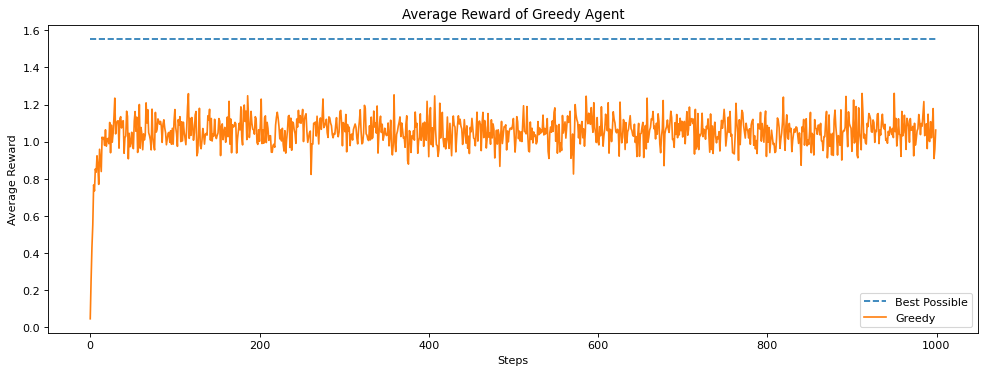

In [22]:
# -----------------------------------------------------------
# Experiment: evaluating the performance of a greedy agent
# -----------------------------------------------------------

# Experiment settings
num_runs = 200                    # The number of independent experiment runs
num_steps = 1000                  # The number of actions taken in each run

# Environment and agent selection
env = ten_arm_env.Environment      # Choosing the 10-armed bandit environment
agent = GreedyAgent                # Selecting the greedy agent for evaluation

# Configuration settings for the agent and environment
agent_info = {"num_actions": 10}   # Passing the number of arms to the agent
env_info = {}                      # No additional parameters needed for the environment

# Initializing reward tracking
rewards = np.zeros((num_runs, num_steps))  # Stores rewards for each run at each step
average_best = 0  # Tracks the average optimal reward across runs

# Running multiple independent experiments
for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    # Initialize the RLGlue framework with the selected environment and agent
    rl_glue = RLGlue(env, agent)  
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    # Track the best possible action's reward for comparison
    average_best += np.max(rl_glue.environment.arms)

    # Run the experiment for the defined number of steps
    for i in range(num_steps):
        # Take a step in the environment and get feedback
        reward, _, _, _ = rl_glue.rl_step(i)  # Pass `i` as the time step
        
        # Store the received reward for later analysis
        rewards[run, i] = reward  

# Compute the average reward across all runs
greedy_scores = np.mean(rewards, axis=0)

# Visualization of results
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()


**How did our agent do? Is it possible for it to do better?**

The agent performs well but doesn't reach the highest possible reward because it always picks the action that seemed best in the past without trying other options. This can lead to missing out on better choices that haven't been tested enough. A better approach would involve occasionally trying different actions to gather more information while still favoring the best-known option. This balance would help improve performance over time and get closer to the best possible reward.

## **Section 2: Epsilon-Greedy Agent**

We learned about another way for an agent to operate, where it does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

Implement an epsilon-greedy agent below. You may want to use your greedy code from above and look at [np.random.random](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html), as well as [np.random.randint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html), to help you select random actions. 

In [24]:
import numpy as np
import main_agent  # Assuming this contains the base Agent class

class EpsilonGreedyAgent(main_agent.Agent):
    """
    An epsilon-greedy agent that balances exploration and exploitation.
    It updates its Q-values based on received rewards and selects actions 
    either greedily (most rewarding) or randomly (exploration) based on epsilon.
    """

    def __init__(self):
        """Initialize agent variables."""
        self.q_values = None  # Estimated action values
        self.arm_count = None  # Number of times each action has been selected
        self.last_action = None  # Last action taken
        self.epsilon = None  # Exploration probability

    def agent_init(self, agent_info):
        """
        Initializes agent parameters at the beginning of an experiment.

        Parameters:
        agent_info (dict): Contains 'num_actions' (number of actions) and 'epsilon'.
        """
        self.num_actions = agent_info["num_actions"]  # <-- Add this line
        self.epsilon = agent_info.get("epsilon", 0.1)

        self.q_values = np.zeros(self.num_actions)
        self.arm_count = np.zeros(self.num_actions)

    def agent_step(self, t, reward, observation=None):
        """
        Executes one step in the agent's decision-making process.

        Parameters:
        t (int): The current time step.
        reward (float): The reward received from the environment after the last action.
        observation (float, optional): The observed state of the environment.

        Returns:
        int: The action chosen by the agent at the current time step.
        """

        # Step 1: Update Q-values using an incremental update rule
        if self.last_action is not None:
            self.arm_count[self.last_action] += 1  # Increment count for selected action
            step_size = 1 / self.arm_count[self.last_action]  # α = 1/N(a)
            self.q_values[self.last_action] += step_size * (reward - self.q_values[self.last_action])

        # Step 2: Choose an action using the epsilon-greedy strategy
        if np.random.rand() < self.epsilon:  # Exploration: Random action
            current_action = np.random.choice(len(self.q_values))
        else:  # Exploitation: Select action with highest Q-value
            current_action = np.argmax(self.q_values)

        # Step 3: Store the chosen action for the next update
        self.last_action = current_action

        return current_action


Now that we have our epsilon greedy agent created. Let's compare it against the greedy agent with epsilon of 0.1.

  0%|          | 1/200 [00:00<00:32,  6.07it/s]

100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


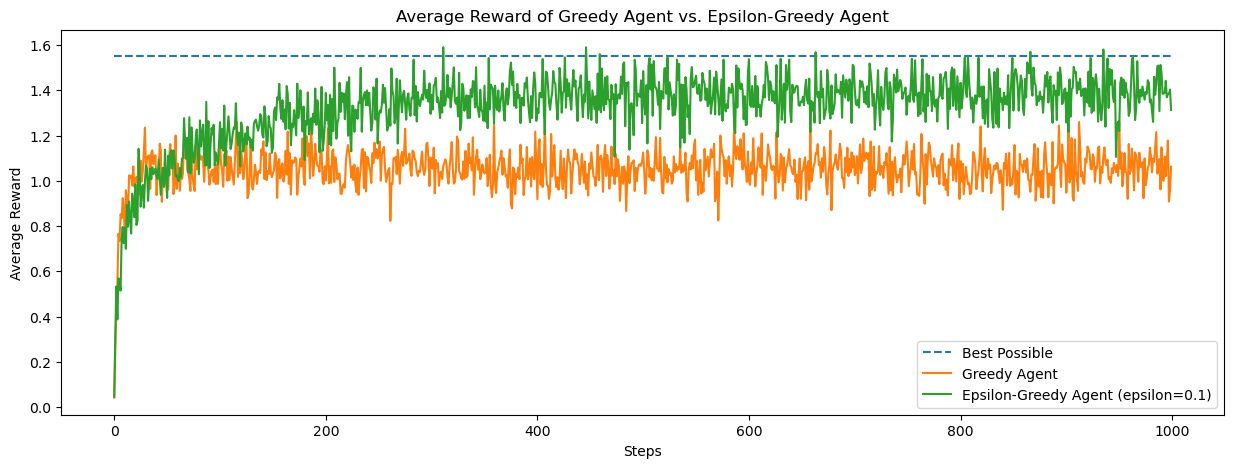

In [25]:
# -----------------------------------------------------------
# Comparing greedy and epsilon-greedy agent performance
# -----------------------------------------------------------

num_runs = 200                    # Number of independent experiment runs
num_steps = 1000                  # Number of actions taken in each run
epsilon = 0.1                     # Exploration probability for the epsilon-greedy agent

# Configuration settings for the agent and environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
greedy_agent_info = {"num_actions": 10, "epsilon": 0.0}  # Greedy agent has epsilon = 0
env_info = {}

# Initializing reward tracking
epsilon_greedy_rewards = np.zeros((num_runs, num_steps))
greedy_rewards = np.zeros((num_runs, num_steps))

# Running experiments for epsilon-greedy agent
for run in tqdm(range(num_runs)):
    np.random.seed(run)
    rl_glue = RLGlue(ten_arm_env.Environment, EpsilonGreedyAgent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for step in range(num_steps):
        reward, _, _, _ = rl_glue.rl_step(step)
        epsilon_greedy_rewards[run, step] = reward

# Running experiments for greedy agent
for run in tqdm(range(num_runs)):
    np.random.seed(run)
    rl_glue = RLGlue(ten_arm_env.Environment, GreedyAgent)
    rl_glue.rl_init(greedy_agent_info, env_info)
    rl_glue.rl_start()

    for step in range(num_steps):
        reward, _, _, _ = rl_glue.rl_step(step)
        greedy_rewards[run, step] = reward

# Compute the average reward over all runs
epsilon_greedy_scores = np.mean(epsilon_greedy_rewards, axis=0)
greedy_scores = np.mean(greedy_rewards, axis=0)

# Visualization of results
plt.figure(figsize=(15, 5))
plt.plot([1.55 for _ in range(num_steps)], linestyle="--", label="Best Possible")
plt.plot(greedy_scores, label="Greedy Agent")
plt.plot(epsilon_greedy_scores, label=f"Epsilon-Greedy Agent (epsilon={epsilon})")
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()


**Why does the epsilon-greedy strategy often lead to better long-term performance in reinforcement learning?**

The **epsilon-greedy strategy** leads to **better long-term performance** in reinforcement learning because it **balances exploration and exploitation**. It **mostly chooses the best-known action** (exploitation) but **sometimes tries random actions** (exploration). This **prevents the agent from getting stuck in suboptimal choices** and **helps discover better actions over time**, leading to **more accurate value estimates and improved performance** in the long run.

## **Section 2.1 Averaging Multiple Runs**

Did you notice that we averaged over 200 runs? Why did we do that?

To get some insight, let's look at the results of two individual runs by the same agent.

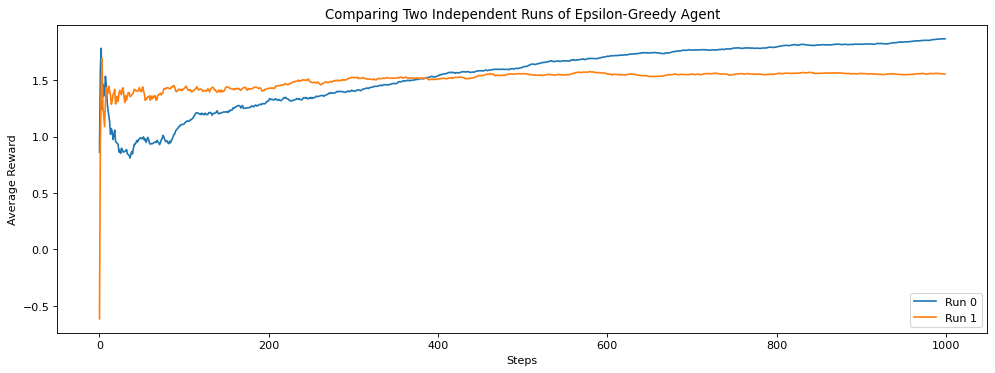

In [27]:
# -------------------------------------------------------------
# Visualizing two independent runs of the epsilon-greedy agent
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from rlglue.rl_glue import RLGlue
import ten_arm_env
import main_agent

# Select the agent and environment for the experiment
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment

# Define agent and environment configurations
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}

# Set up the figure for plotting results
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Number of steps each agent takes
num_steps = 1000

# Run the experiment twice with different random seeds to compare behaviors
for run in (0, 1):  
    np.random.seed(run)  # Set seed to compare the behavior across different runs
    averages = []  # Track average rewards over time
    
    # Initialize the RLGlue framework with the selected environment and agent
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    # Track cumulative rewards
    scores = [0]  

    for i in range(num_steps):
        # Take a step in the environment and get the reward
        reward, _, action, _ = rl_glue.rl_step(i)  # Pass time step `i`
        
        # Update cumulative reward
        scores.append(scores[-1] + reward)

        # Compute the running average reward
        averages.append(scores[-1] / (i + 1))  

    # Plot the average rewards over time for this run
    plt.plot(averages, label=f"Run {run}")

# Add title, labels, and legend to the plot
plt.title("Comparing Two Independent Runs of Epsilon-Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()


**Notice how the two runs were different? But, if this is the exact same algorithm, why does it behave differently in these two runs?**

The **epsilon-greedy strategy** leads to **better long-term performance** in reinforcement learning because it **balances exploration and exploitation**. It **mostly chooses the best-known action** (exploitation) but **sometimes tries random actions** (exploration). This **prevents the agent from getting stuck in suboptimal choices** and **helps discover better actions over time**, leading to **more accurate value estimates and improved performance** in the long run.

The following script shows how setting different random seeds affects the agent's behavior. Specifically, it determines whether the agent takes an exploratory action based on a 10% probability.

In [28]:
# -----------------------------------------------------------
# Demonstrating the effect of random seeds on exploration
# -----------------------------------------------------------

# First run with Random Seed 1
print("Random Seed 1")
np.random.seed(1)  # Set seed for reproducibility
for _ in range(15):  # Loop for 15 time steps
    if np.random.random() < 0.1:  # 10% chance to take an exploratory action
        print("Exploratory Action")  # Print if exploration occurs

print("\n")

# Second run with Random Seed 2
print("Random Seed 2")
np.random.seed(2)  # Set a different seed to observe changes
for _ in range(15):  # Again, loop for 15 time steps
    if np.random.random() < 0.1:  # 10% chance for exploration
        print("Exploratory Action")  # Print if exploration occurs


Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


With the first seed, we take an exploratory action three times out of 15, but with the second, we only take an exploratory action once. This can significantly affect the performance of our agent because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. We do this to ensure that we are not simply reporting a result that is due to stochasticity. Rather, we want statistically significant outcomes. We will not use statistical significance tests. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

## **Section 3: Comparing values of epsilon**

Can we do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment to show how different values of epsilon (exploration rate) affect the performance of an epsilon-greedy agent in a multi-armed bandit problem. The results are plotted to show the average rewards over time.

  1%|          | 2/200 [00:00<00:14, 13.47it/s]

100%|██████████| 200/200 [00:11<00:00, 16.68it/s]


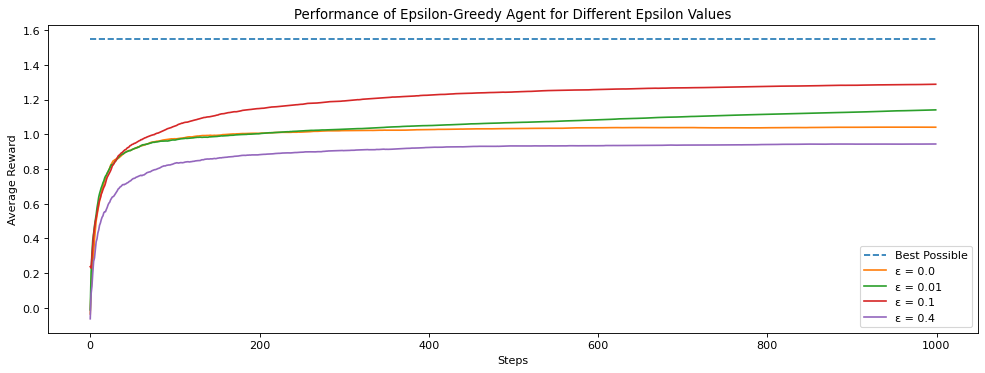

In [30]:
# ------------------------------------------------------------------------
# Comparing different epsilon values in the epsilon-greedy algorithm
# ------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rlglue.rl_glue import RLGlue
import ten_arm_env
import main_agent

# Define different epsilon values to test
epsilons = [0.0, 0.01, 0.1, 0.4]  # 0.0 (greedy), small exploration (0.01), moderate (0.1), high (0.4)

# Set up the figure for plotting
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the optimal possible reward as a reference (dashed line)
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

# Initialize lists to store results
n_q_values = []         # Stores Q-values for epsilon = 0.1 (for later analysis)
n_averages = []         # Stores average rewards for epsilon = 0.1
n_best_actions = []     # Tracks best action selections for epsilon = 0.1

num_runs = 200  # Number of independent experiment runs

# Iterate through each epsilon value and evaluate performance
for epsilon in epsilons:
    all_averages = []  # Store average rewards for all runs

    for run in tqdm(range(num_runs)):  # Progress bar for experiment runs
        agent = EpsilonGreedyAgent  # Use epsilon-greedy agent
        agent_info = {"num_actions": 10, "epsilon": epsilon}  # Set agent parameters
        env_info = {}  # Set environment info (no random seed in RL-Glue)

        # Initialize the RLGlue framework
        rl_glue = RLGlue(ten_arm_env.Environment, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)  # Identify the best possible action

        # Initialize tracking variables
        scores = [0]                # Cumulative rewards
        averages = []               # Running average of rewards
        best_action_chosen = []     # Tracks if the best action was chosen

        for i in range(num_steps):
            # Take a step in the environment and receive feedback
            reward, _, action, _ = rl_glue.rl_step(i)  # Pass time step `i`

            # Update cumulative rewards
            scores.append(scores[-1] + reward)

            # Compute and store the running average reward
            averages.append(scores[-1] / (i + 1))

            # Track if the best action was chosen
            best_action_chosen.append(1 if action == best_arm else 0)

            # Store Q-values for detailed analysis if epsilon = 0.1 and run = 0
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))

        # Store averages and best action tracking for epsilon = 0.1
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)

        all_averages.append(averages)  # Store results for this epsilon value
    
    # Plot the mean performance of this epsilon value across all runs
    plt.plot(np.mean(all_averages, axis=0), label=f"ε = {epsilon}")

# Finalize plot with legend and labels
plt.legend(["Best Possible"] + [f"ε = {e}" for e in epsilons])
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Performance of Epsilon-Greedy Agent for Different Epsilon Values")
plt.show()


**Why did 0.1 perform better than 0.01? If exploration helps why did 0.4 perform worse than 0.0 (the greedy agent)?**

0.1 performed better than 0.01 because it balanced exploration and exploitation better. With ε = 0.1, the agent explored more than when ε = 0.01, helping it discover better actions early on, leading to better long-term performance.

0.4 performed worse than 0.0 (greedy agent) because too much exploration (ε = 0.4) led the agent to frequently choose random actions, reducing its ability to exploit the best actions it had already learned. In contrast, the greedy agent (ε = 0.0) always exploited its current knowledge, which can work well in simple or deterministic environments.

## **Section 4: The effect of step size**

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

In [31]:
# ------------------------------------------------------------------------------
# Epsilon-Greedy agent with a constant step-size update rule
# ------------------------------------------------------------------------------
# This agent follows the epsilon-greedy strategy but updates its Q-values using 
# a constant step size instead of computing an average from past rewards. This 
# allows for a more stable learning process when dealing with non-stationary 
# environments.
# ------------------------------------------------------------------------------

class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, t, reward, observation=None):
        """
        Takes one step for the agent. It receives a reward and (optionally) an 
        observation and returns the action the agent selects at this time step.
        
        Arguments:
        reward -- float, the reward received from the environment after taking 
                  the previous action.
        observation -- float, the observed state of the agent (not used in this 
                       implementation but included for future extensions).
        
        Returns:
        current_action -- int, the action chosen by the agent at the current 
                          time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array storing the agent's estimated values for each action.
        # self.arm_count : An array tracking the number of times each action has been selected.
        # self.last_action : An integer representing the action the agent took in the previous step.
        # self.step_size : A constant float value determining how much the Q-values update.
        # self.epsilon : The probability of selecting a random action for exploration.
        ###############################

        # Step 1: Update Q-values using a constant step size update rule
        # Unlike traditional incremental averaging, this approach does not depend on 
        # self.arm_count and instead uses a predefined step size.
        self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])    

        # Step 2: Choose the next action using the epsilon-greedy strategy:
        if np.random.rand() < self.epsilon:
            current_action = np.random.choice(self.num_actions)  # Explore
        else:
            current_action = argmax(self.q_values)  # Exploit

        # Step 3: Store the chosen action for reference in the next step
        self.last_action = current_action
        
        return current_action


Let's compare the performance of epsilon-greedy agents using different step size update rules. The step size controls how much each new reward influences the agent’s estimated Q-values.

**Step sizes tested**:
- 0.01, 0.1, 0.5, 1.0: Constant step sizes
- 1/N(A): Incremental averaging (1 divided by the number of times an action has been selected).

Note that performance is measured by tracking the percentage of times the agent selects the optimal action over 1000 steps, averaged over 200 independent runs.

100%|██████████| 200/200 [00:16<00:00, 12.20it/s]
/tmp/ipykernel_54701/3329014277.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


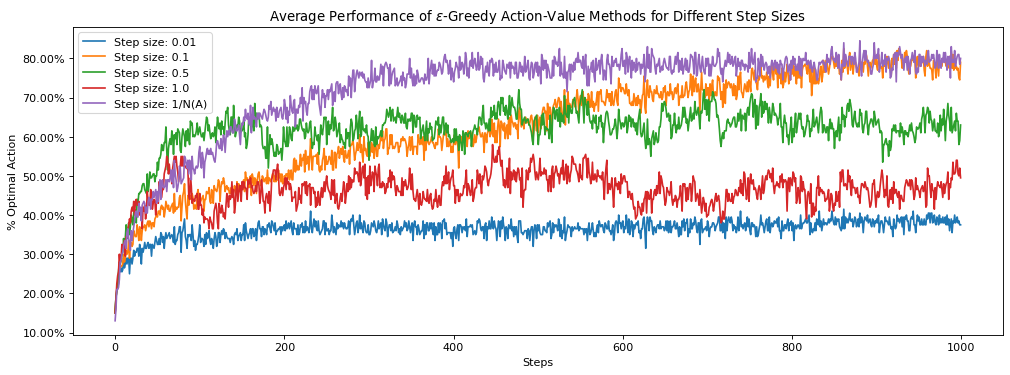

In [32]:
# -----------------------------------------------------------------------------------------
# Experiment: evaluating the performance of epsilon-greedy agents with different step sizes
# -----------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rlglue.rl_glue import RLGlue
import ten_arm_env
import main_agent

# Define different step-size strategies
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']  # Different step size strategies
epsilon = 0.1  # Probability of exploration
num_steps = 1000  # Number of steps per run
num_runs = 200  # Number of independent runs

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Data structures for storing experiment results
q_values = {step_size: [] for step_size in step_sizes}  # Q-values per step size
true_values = {step_size: None for step_size in step_sizes}  # True values of each action
best_actions = {step_size: [] for step_size in step_sizes}  # Optimal action selections

# Run experiment for each step size
for step_size in step_sizes:
    all_averages = []  # Store average performance per run
    
    for run in tqdm(range(num_runs)):  # Iterate over multiple runs
        np.random.seed(run)  # Ensure reproducibility

        # Select the appropriate agent based on step size
        if step_size == '1/N(A)':
            agent = EpsilonGreedyAgent  # Uses incremental averaging
            agent_info = {"num_actions": 10, "epsilon": epsilon}
        else:
            agent = EpsilonGreedyAgentConstantStepsize  # Uses constant step size
            agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}

        env_info = {}

        # Initialize RLGlue framework
        rl_glue = RLGlue(ten_arm_env.Environment, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)  # Identify the optimal action

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)  # Store true action values

        best_action_chosen = []  # Track if the optimal action was chosen
        
        for i in range(num_steps):
            # Run the RL step function
            reward, _, action, _ = rl_glue.rl_step(i)

            # Check if the chosen action is the optimal one
            best_action_chosen.append(1 if action == best_arm else 0)

            # Store Q-values for the first run
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        
        best_actions[step_size].append(best_action_chosen)  # Store results for this run
    
    # Compute the average optimal action percentage over all runs and plot
    ax.plot(np.mean(best_actions[step_size], axis=0), label=f"Step size: {step_size}")

# Configure and display plot
plt.legend()
plt.title("Average Performance of $\epsilon$-Greedy Action-Value Methods for Different Step Sizes")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()


Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better  understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

**It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?**

1. **1/N(A) performed better:**  
   - **1/N(A)** is a **sample average update rule**, meaning it gradually **reduces the step size** over time. Early on, it **adapts quickly**, and later it **stabilizes**, allowing it to converge to the **true action values** more reliably.

2. **Step size 0.5 started better but ended worse:**  
   - **Large step size (0.5)** allows **fast initial learning**, but it **introduces high variance later**, causing **instability** and **preventing convergence** to the optimal action.

3. **Step size 0.01 performed poorly:**  
   - **Small step size (0.01)** leads to **slow learning**, making it **take a long time** to adjust to better actions, which results in **poor performance**, especially in the early stages.

### **Estimated values vs. Expected values**
So, the goal now is to observe how quickly and accurately different step sizes allow the agent to approximate the true value of the optimal action.

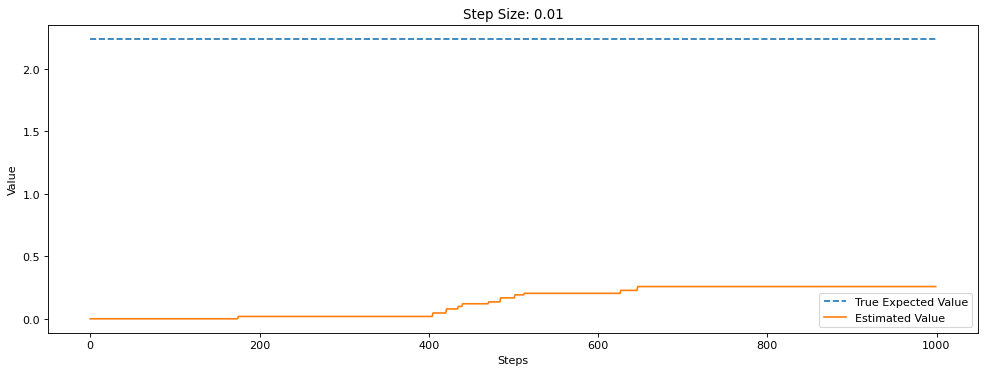

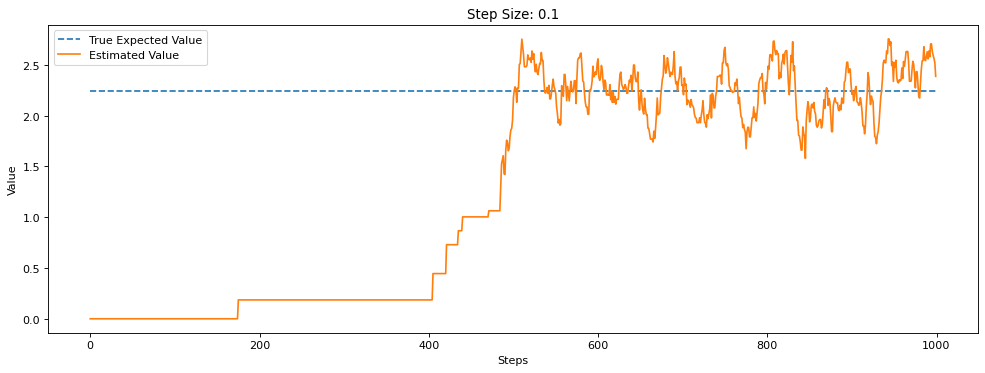

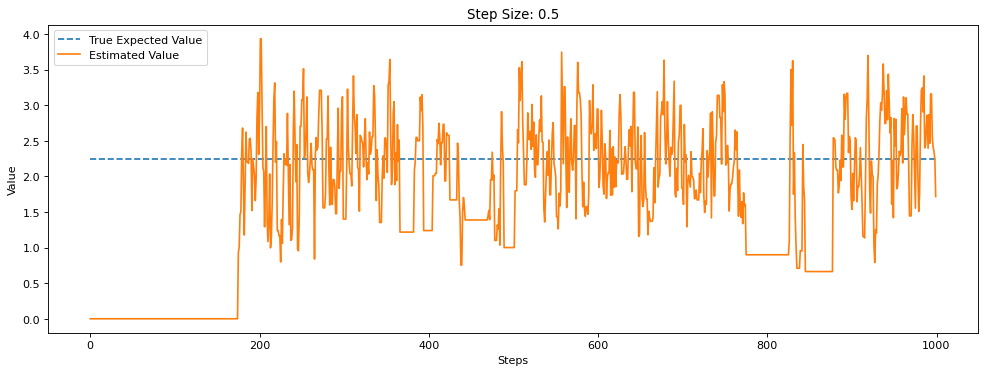

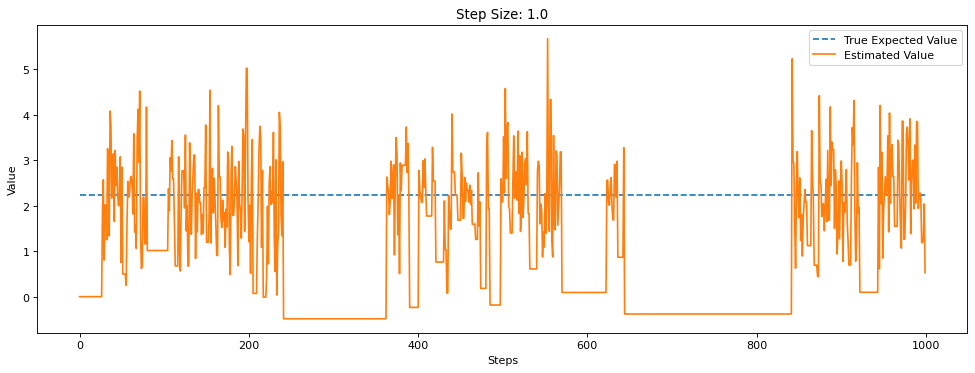

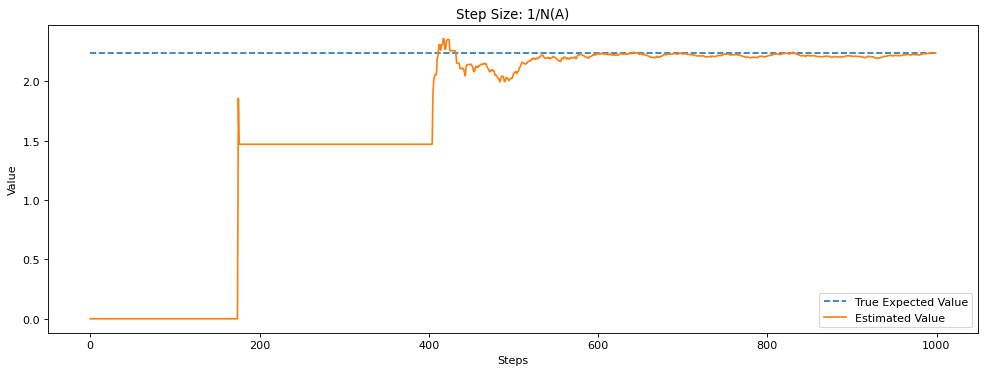

In [33]:
# --------------------------------------------------------------------------------
# Visualizing estimated Q-Values vs. true expected values for different step sizes
# --------------------------------------------------------------------------------

num_steps = 1000  # Number of steps in each run

# Iterate over each step size to generate a plot
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

    # Identify the action with the highest true expected value
    largest = np.argmax(true_values[step_size])  # Get index of the best action
    
    # Plot the true expected value of the best action as a reference
    plt.plot([true_values[step_size][largest]] * num_steps, linestyle="--", label="True Expected Value")

    # Convert q_values list to numpy array for easy indexing
    q_values_matrix = np.array(q_values[step_size])  # Shape: (num_steps, num_actions)
    
    # Plot the estimated Q-value of the best action over time
    plt.plot(q_values_matrix[:, largest], label="Estimated Value")

    # Configure plot settings
    plt.title(f"Step Size: {step_size}")
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.legend()
    
    # Show the plot
    plt.show()

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is.  A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

**Does this mean that 1/N(A) is always the best? When might it not be?**

**No, 1/N(A) is not always the best.**  
While **1/N(A)** generally works well in **stationary environments** (where action values don’t change), it can **struggle in non-stationary environments** (where action values change over time).

### When might **1/N(A)** not be the best?
- **Non-stationary environments:**  
  Since **1/N(A)** **reduces the step size over time**, it becomes **slow to adapt** to changes in action values later in learning.
- **Better alternative for non-stationary environments:**  
  **A constant step size (e.g., 0.1)** allows **continuous adaptation** to changes in action values, making it **better suited** for **dynamic environments**.

**Key Idea:**  
- **1/N(A)** → **Good for stationary environments.**  
- **Constant step size (e.g., 0.1)** → **Better for non-stationary environments.**

### **Non-stationary problems**
Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time. 

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:45<00:00,  3.03it/s]


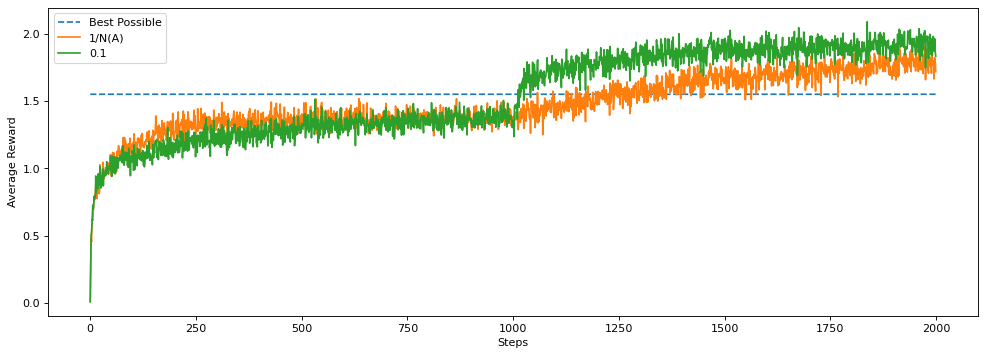

In [34]:
# ------------------------------------------------------------------------------
# Comparing standard and constant step-size epsilon-greedy agents over time
# ------------------------------------------------------------------------------
# This script evaluates two different epsilon-greedy agents:
# 1. EpsilonGreedyAgent (with 1/N(A) step size).
# 2. EpsilonGreedyAgentConstantStepsize (with a fixed step size of 0.1).
#
# The experiment runs each agent for multiple episodes and compares their 
# performance based on average rewards over time. Additionally, at step 1000, 
# the environment’s reward distribution shifts to test adaptability.
# ------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rlglue.rl_glue import RLGlue
import ten_arm_env
import main_agent

epsilon = 0.1         # Probability of exploration
num_steps = 2000      # Total number of steps per run
num_runs = 500        # Number of independent runs for averaging
step_size = 0.1       # Fixed step size for constant step-size agent

# Initialize the plot
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the best possible reward as a reference
plt.plot([1.55 for _ in range(num_steps)], linestyle="--", label="Best Possible")

# Iterate over both agent types
for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    rewards = np.zeros((num_runs, num_steps))  # Store rewards for averaging
    
    # Run multiple experiments to get a stable average performance
    for run in tqdm(range(num_runs)):
        np.random.seed(run)  # Set seed for reproducibility

        # Select appropriate agent
        if agent == EpsilonGreedyAgent:
            agent_info = {"num_actions": 10, "epsilon": epsilon}
        else:
            agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}

        env_info = {}

        # Initialize RL environment and agent
        rl_glue = RLGlue(ten_arm_env.Environment, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        for i in range(num_steps):
            # Take a step in the environment
            reward, _, action, _ = rl_glue.rl_step(i)

            # Store received reward
            rewards[run, i] = reward

            # Introduce a shift in rewards at step 1000 to test adaptability
            if i == 1000:
                rl_glue.environment.arms += np.random.normal(0, 1, size=10)

    # Plot the average rewards for each agent
    plt.plot(np.mean(rewards, axis=0), label="1/N(A)" if agent == EpsilonGreedyAgent else "0.1")

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()


**Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?**

## **Section 5: Upper-Confidence-Bound (UCB) Action Selection**

The **Upper-Confidence-Bound (UCB)** action selection method improves exploration by selecting actions based on their estimated value and an exploration bonus using the following formula:
  $$
  A_t = \arg\max_{a} \left( Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right)
  $$
  where:
  - \(Q_t(a)\) is the estimated value of action \(a\).
  - \(N_t(a)\) is the number of times action \(a\) has been selected.
  - \(t\) is the current time step.
  - \(c\) is a constant that controls exploration.

Complete the function that selects an action based on UCB.

In [35]:
import numpy as np

class UCBAgent(main_agent.Agent):
    def agent_step(self, t, reward, observation=None):
        """
        Selects an action based on the Upper Confidence Bound (UCB) strategy.

        Arguments:
        t -- int, current time step.
        reward -- float, the reward received from the previous action.
        observation -- float, observed state (not used in this implementation).

        Returns:
        current_action -- int, the action selected by the agent.
        """

        # Ensure q_values and arm_count are NumPy arrays for efficient computation
        if isinstance(self.q_values, list):
            self.q_values = np.array(self.q_values)
        if isinstance(self.arm_count, list):
            self.arm_count = np.array(self.arm_count)

        # Step 1: Update Q-values using an incremental update rule
        if self.last_action is not None:  # Ensure it's not the first step
            action = self.last_action
            self.arm_count[action] += 1  # Update count for the chosen action
            step_size = 1.0 / self.arm_count[action]  # α = 1/N(a)
            self.q_values[action] += step_size * (reward - self.q_values[action])  # Update Q(a)

        # Step 2: Compute UCB Estimates
        # Q(a) + c * sqrt( log(t + 1) / (N(a) + 1e-5) )
        confidence_bonus = self.ucb_parameter * np.sqrt(np.log(t + 1) / (self.arm_count + 1e-5))
        ucb_estimates = self.q_values + confidence_bonus

        # Step 3: Select Action
        current_action = np.argmax(ucb_estimates)  # Choose action with highest UCB estimate

        # Store the selected action for the next step
        self.last_action = current_action

        return current_action


The following experiment compares the performance of Epsilon-Greedy Agent (ε = 0.1) and Upper Confidence Bound (UCB) Agent (c = 2.0). The goal is to analyze how these two strategies perform over time in terms of the obtained average reward.

  0%|          | 1/200 [00:00<00:32,  6.17it/s]

100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


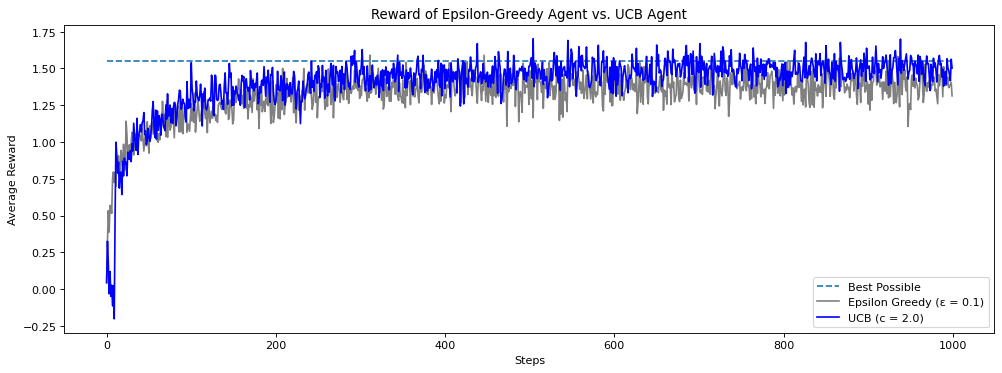

In [36]:
# ------------------------------------------------------------------------------
# Comparing epsilon-greedy and UCB agents
# ------------------------------------------------------------------------------

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Experiment Parameters
num_runs = 200         # Number of independent simulation runs
num_steps = 1000       # Number of time steps per run
epsilon = 0.1          # Exploration probability for epsilon-greedy agent
ucb_parameter = 2.0    # Exploration factor for UCB agent

# Define the environment
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon, "ucb_parameter": ucb_parameter}
env_info = {}

# Initialize array to store rewards for each run and step
all_rewards = np.zeros((num_runs, num_steps))

# Running Multiple Simulations
for run in tqdm(range(num_runs)):
    np.random.seed(run)

    # Initialize RLGlue framework for UCB agent
    rl_glue = RLGlue(env, UCBAgent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    # Simulate agent learning process over `num_steps`
    for i in range(num_steps):
        step_result = rl_glue.rl_step(i)  # Take a step in the environment

        # Check if step_result is a tuple or a single value
        if isinstance(step_result, tuple):
            reward = step_result[0]  # Extract the reward
        else:
            reward = step_result  # Assume it's just the reward

        # Store reward for analysis
        all_rewards[run, i] = reward  

# Compute the average reward across all runs for each time step
ucb_scores = np.mean(all_rewards, axis=0)

# Plot Results
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--", label="Best Possible")
plt.plot(epsilon_greedy_scores, color='grey', label=f"Epsilon Greedy (ε = {epsilon})")
plt.plot(ucb_scores, color='blue', label=f"UCB (c = {ucb_parameter})")
plt.title("Reward of Epsilon-Greedy Agent vs. UCB Agent")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()


**How does the choice of the parameter $c$ affect the agent's performance? How does UCB compare to epsilon-greedy in terms of regret minimization?**

1. **Effect of the parameter \(c\) in UCB:**
   - \(c\) **controls the balance between exploration and exploitation** in the **Upper Confidence Bound (UCB)** algorithm.
   - **Small \(c\)** → **Less exploration**: The agent becomes more **greedy**, focusing on actions that seem best early on, risking **suboptimal choices**.
   - **Large \(c\)** → **More exploration**: The agent **explores more**, but **spends too much time trying suboptimal actions**, slowing down the convergence to the best action.
   - **Optimal \(c\)** → Achieves a **good balance**, exploring **enough** but **quickly settling** on the **best action**.

2. **UCB vs. Epsilon-Greedy (in terms of regret minimization):**
   - **UCB generally outperforms epsilon-greedy** in **regret minimization** because it **explores more intelligently**.
   - **Epsilon-greedy** explores **randomly**, leading to **unnecessary exploration** of **clearly bad actions**.
   - **UCB** focuses on **uncertainty-based exploration**, reducing **regret** by **exploring only when needed**, making it **more sample-efficient**.
   - **Result:**  
     - **UCB → Lower regret in the long run** (especially when \(T\) is large).  
     - **Epsilon-greedy → Higher regret** because of **constant random exploration**.

## **Section 6: Gradient Bandit Algorithm**
The **Gradient Bandit Algorithm** selects actions using a preference function, which is updated based on rewards received.

Implement a bandit agent that uses the **Gradient Bandit Algorithm** using the following update rules:
  $$
  H_t(a) \leftarrow H_t(a) + \alpha (R_t - \bar{R}_t) (1 - P_t(a))
  $$
  where:
  - $H_t(a)$ is the preference for action $a$.
  - $P_t(a)$ is the probability of selecting action $a$ (computed using a softmax function).
  - $\bar{R}_t$ is the running average of past rewards.
  - $\alpha$ is a step-size parameter.
- Compare the performance of the Gradient Bandit Algorithm with epsilon-greedy and UCB.
- Plot the action probabilities over time.

In [37]:
import numpy as np

class GradientBanditAgent(main_agent.Agent):
    def agent_step(self, t, reward, observation=None):
        """
        Executes a step for the Gradient Bandit Agent.

        Arguments:
        t -- int, current time step.
        reward -- float, reward received after taking the last action.
        observation -- float, observed state (not used in this implementation).

        Returns:
        current_action -- int, action chosen by the agent at this time step.
        """

        self.indices = np.arange(len(self.q_values))  # Array of action indices

        # Ensure q_values and arm_count are NumPy arrays for efficient calculations
        if isinstance(self.q_values, list):
            self.q_values = np.array(self.q_values)
        if isinstance(self.arm_count, list):
            self.arm_count = np.array(self.arm_count)

        # Step 1: Update the average reward estimate (baseline for variance reduction)
        if t == 0:
            self.avg_reward = reward  # Initialize on first step
        else:
            self.avg_reward += (reward - self.avg_reward) / (t + 1)  # Incremental update

        # Step 2: Compute the preference update (Policy Gradient Update Rule)
        preferences = np.exp(self.q_values)  # Convert preferences into exponentiated values
        action_probabilities = preferences / np.sum(preferences)  # Softmax normalization

        if self.gradient_baseline:
            baseline = self.avg_reward  # Use average reward as a baseline
        else:
            baseline = 0  # No baseline subtraction

        # Update preferences based on the reward signal
        for action in range(len(self.q_values)):
            if action == self.last_action:
                self.q_values[action] += self.alpha * (reward - baseline) * (1 - action_probabilities[action])
            else:
                self.q_values[action] -= self.alpha * (reward - baseline) * action_probabilities[action]

        # Step 3: Compute new action probabilities using Softmax
        preferences = np.exp(self.q_values)  # Convert updated preferences to exponentiated values
        action_probabilities = preferences / np.sum(preferences)  # Recompute softmax probabilities

        # Step 4: Select an action based on the updated probabilities
        current_action = np.random.choice(self.indices, p=action_probabilities)

        # Update last action for the next step
        self.last_action = current_action

        return current_action


This experiment evaluates the Gradient Bandit Algorithm on a 10-armed testbed. We analyze performance across different step sizes (α) and with/without baseline rewards. The baseline helps reduce variance, leading to more stable learning.

Running step_size=0.4, baseline=False: 100%|██████████| 500/500 [03:22<00:00,  2.47it/s]
/tmp/ipykernel_54701/1671626179.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0%}" for x in vals])


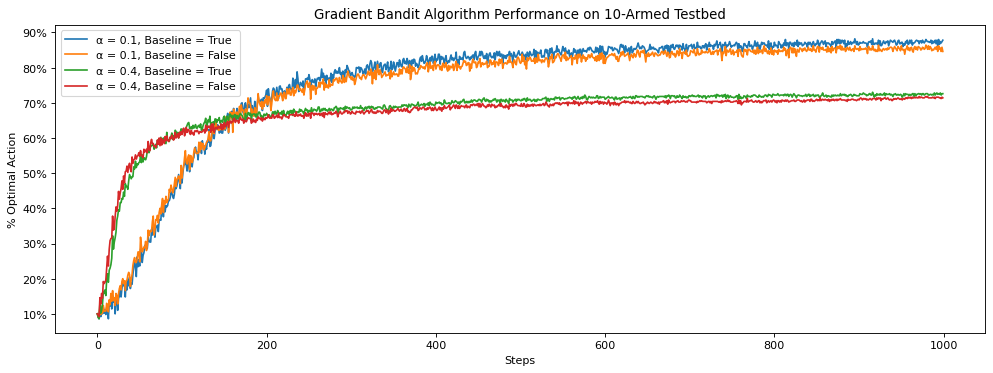

In [38]:
# ------------------------------------------------------------------------------------------------
# Experiment: gradient bandit algorithm with different step-sizes and baselines
# ------------------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class GradientBanditAgent:
    def __init__(self, num_actions, step_size, use_baseline):
        self.num_actions = num_actions
        self.step_size = step_size
        self.use_baseline = use_baseline
        self.preferences = np.zeros(num_actions)
        self.action_counts = np.zeros(num_actions)
        self.average_reward = 0

    def select_action(self):
        probabilities = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        return np.random.choice(self.num_actions, p=probabilities)

    def update_preferences(self, action, reward):
        self.action_counts[action] += 1
        self.average_reward += (reward - self.average_reward) / np.sum(self.action_counts)

        probabilities = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        baseline = self.average_reward if self.use_baseline else 0
        for a in range(self.num_actions):
            if a == action:
                self.preferences[a] += self.step_size * (reward - baseline) * (1 - probabilities[a])
            else:
                self.preferences[a] -= self.step_size * (reward - baseline) * probabilities[a]


# Step sizes (α) and Baseline Variants to test
step_sizes = [0.1, 0.4]  # Learning rates for updating action preferences
gradient_baselines = [True, False]  # Whether to use a baseline reward estimate

# Experiment parameters
num_runs = 500  # Number of independent runs for averaging
num_steps = 1000  # Number of steps per run
num_actions = 10

# Data storage for analysis
best_actions = {step_size: [] for step_size in step_sizes}  # Optimal action selection tracking
legends = []  # Legends for the plot

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Run the experiment for each step size and baseline combination
for step_size in step_sizes:
    for gradient_baseline in gradient_baselines:
        best_action_counts = []

        for run in tqdm(range(num_runs), desc=f"Running step_size={step_size}, baseline={gradient_baseline}"):
            np.random.seed(run)
            true_action_values = np.random.normal(0, 1, num_actions)
            best_action = np.argmax(true_action_values)

            agent = GradientBanditAgent(num_actions, step_size, gradient_baseline)

            best_action_chosen = []
            for i in range(num_steps):
                action = agent.select_action()
                reward = np.random.normal(true_action_values[action], 1)
                agent.update_preferences(action, reward)

                best_action_chosen.append(1 if action == best_action else 0)

            best_action_counts.append(best_action_chosen)

        best_actions[step_size].append(np.mean(best_action_counts, axis=0))

        legend_text = f"α = {step_size}, Baseline = {gradient_baseline}"
        legends.append(legend_text)
        ax.plot(np.mean(best_action_counts, axis=0), label=legend_text)

plt.legend()
plt.title("Gradient Bandit Algorithm Performance on 10-Armed Testbed")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
vals = ax.get_yticks()
ax.set_yticklabels([f"{x:.0%}" for x in vals])
plt.show()


**How does the step-size $\alpha$ affect the convergence of the Gradient Bandit Algorithm? Does the algorithm perform better in non-stationary environments?**

The step-size \(\alpha\) in the Gradient Bandit Algorithm plays a crucial role in determining how quickly the algorithm updates its action preferences based on received rewards:

1. **Convergence**:  
   - **Small \(\alpha\)** (e.g., 0.1) leads to **slower updates**, causing the algorithm to converge more **steadily** but **slowly** to optimal actions.
   - **Large \(\alpha\)** (e.g., 0.4) results in **faster updates**, which can help the agent **adapt quickly** but may also cause **instability** if the reward distribution is noisy, leading to oscillations around the optimal action.

2. **Performance in Non-Stationary Environments**:  
   - In **non-stationary environments** (where action values change over time), **larger \(\alpha\)** is generally **better** because it allows the agent to **adapt quickly** to changes.
   - **Smaller \(\alpha\)** would **struggle** in such environments, as it gives **too much weight** to older experiences, making it **slow to respond** to new optimal actions.

**Key takeaway:**  
- **Stationary environments → Moderate \(\alpha\)** is often best.
- **Non-stationary environments → Larger \(\alpha\)** generally improves adaptation.

## **Section 7: Conclusion**

Great work! You have:
- Implemented your first agent
- Learned about the effect of epsilon, an exploration parameter, on the performance of an agent
- Learned about the effect of step size on the performance of the agent.
- Learn to solve the multi-armed bandits problem based on several methods.  
- Learned about a good experiment practice of averaging across multiple runs.